In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
chains_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/'
datadir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
plot_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/plots/'

In [4]:
with open(datadir + 'MDPL2_DS_Rvir_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x', 'y', 'z',
       'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## User Defined Functions

#### KLLR for Covariance

In [5]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

#### Likelihood functions and fit

In [6]:
from mcmc_full_models import *

## Data vectors

### Dictionary of model specifications

In [7]:
model_dict ={'logistics':{'Ndim':4, 'model_func':model_logistics, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             #'logistics_gen':{'Ndim':5, 'model_func': model_logistics_gen, 'x0':[0.5, -0.5, -1, 1.5e12, 1], 'x_final:':[],
             #            },
             
             'algebraic_2nd':{'Ndim':4, 'model_func':model_algebraic_2nd, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             #'algebraic_gen':{'Ndim':5, 'model_func':model_algebraic_gen, 'x0':[0.5, -0.5, -1, 1.5e12, 1], 'x_final:':[],
             #           },
             
             'arctan':{'Ndim':4, 'model_func':model_arctan, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'erf':{'Ndim':4, 'model_func':model_erf, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         }
            }

### Radial Bins

In [8]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

### Benchmark Testing using one bin

z=0.00, [1e14,2e14] normalized by R200c. 

In [ ]:
nBootstrap = 10
mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        


In [ ]:
## Testing out the functions

for k,v in model_dict.items():
    #Ndim = model_dict['logistics']['Ndim']
    print(k)
    model = v['model_func']
    x0 = v['x0']
    plt.plot(x_data, model(x0, x_data), label=k)
    
plt.errorbar(x_data, y_data, yerr=y_err, label='Data')
plt.legend()
plt.show()

In [ ]:
import corner
##Running the chains
Nwalker = 50
Nsample = int(1e4)

mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

redshift = 1/cur_a_bin - 1
redshift_str = '{:.2f}'.format(redshift)
redshift_str = redshift_str.replace('.','p')

mpl.style.use('default')
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,8), sharex=True)

i=0
for k,v in model_dict.items():
    if k != 'erf': continue
    print(k)
    Ndim = v['Ndim']
    model = v['model_func']
    x0 = v['x0']
    
    
    filename = datadir+"test_chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, k)

    best_fit_params, chain = run_model_chains(Nwalker, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                     burn_in=500, thin=100, maxlag=1000, savefile=False, filename=filename, verbose=True)
    
    model_dict[k]['x_final'] = best_fit_params
    Ndim = model_dict[k]['Ndim']
    fit = model(best_fit_params[:,0], x_data)
    
    flatchain=chain.reshape((-1,Ndim)).T
    best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(flatchain, model, Ndim, x_data, y_data, y_err, verbose=True)
    
    a0.plot(x_data, fit, label=k, color='C{}'.format(i), linewidth=3)
    a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(i), label=k)
    i+=1
    
a0.axhline(0, linestyle='--', color='black')
a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='green')  
a0.legend(loc='upper left', fontsize=20)
a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

a1.axhline(0, linestyle='--', color='black')
#a1.set_ylim([-6e11,3e11])
a1.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Obs} - \rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Fit}$', fontsize=14)
a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(5e13,1e14,0.00), fontsize=20)

f.tight_layout()
#f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
plt.show()


In [ ]:
plt.plot(chain[:,1,0])

In [ ]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e10,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')

In [ ]:
plot_best_fit_params(model_dict)

### Run for all

### Binning and configuration

In [31]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
#mass_bin_edges = [5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
a_bins = [1, 0.6712, 0.4922]
#a_bins = [0.6712]


In [32]:
## MCMC config
Nwalkers = 50
Nsample = int(1e4)
burn_in = 500
thin = 50 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [33]:
radius_bins_dir = {'R200c_binned_Dsep_1Mpc':'R200c_binned/Dsep_1/', \
                   'R200c_binned_Dsep_R200c':'R200c_binned/Dsep_R200c/', \
                   'Rvir_binned_Dsep_1':'Rvir_binned/Dsep_1/', \
                   'Rvir_binned_Dsep_Rvir':'Rvir_binned/Dsep_Rvir/'}

M5e+13-1e+14, z=0.00, 489
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 525.477748
         Iterations: 240
         Function evaluations: 537


100%|██████████| 10000/10000 [01:09<00:00, 144.90it/s]


param_0: best fit, upper_err, lower_err:  [0.34295092 0.05531651 0.04442595]
param_1: best fit, upper_err, lower_err:  [-0.6544671   0.05725875  0.07893856]
param_2: best fit, upper_err, lower_err:  [-1.02372314  0.01438599  0.01609956]
param_3: best fit, upper_err, lower_err:  [1.39711116e+12 3.11875098e+11 1.99371084e+11]
DIC:  [1059.09728119]
BIC:  [1063.00614994]
Chi-square p-value:  0.8472887721778033
Starting params:  [ 3.33469135e-01 -6.42600231e-01 -1.02627060e+00  1.36098843e+12] Minimization convergence:  True
Autocorrelation:  [64.5239258  70.77369545 54.99717635 74.45873259]
R = [1.00297854 1.00251292 1.00170243 1.00317496]


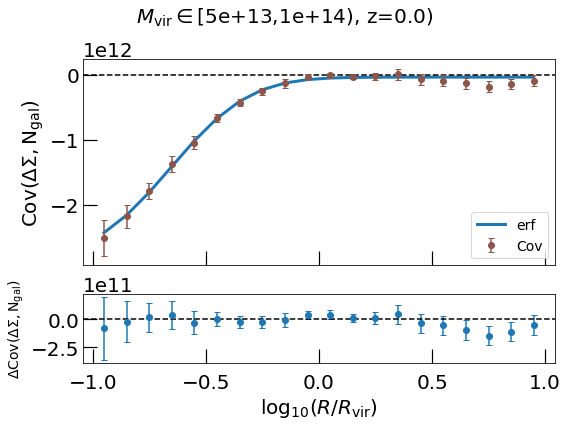

M5e+13-1e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 504.544893
         Iterations: 254
         Function evaluations: 552


100%|██████████| 10000/10000 [01:05<00:00, 152.00it/s]


param_0: best fit, upper_err, lower_err:  [0.50629376 0.13080175 0.09450001]
param_1: best fit, upper_err, lower_err:  [-0.82538696  0.15814569  0.27776007]
param_2: best fit, upper_err, lower_err:  [-1.00298716  0.00459766  0.00706352]
param_3: best fit, upper_err, lower_err:  [9.60518971e+11 7.20572052e+11 2.77911659e+11]
DIC:  [1016.89045426]
BIC:  [1021.18313202]
Chi-square p-value:  0.9999725318158275
Starting params:  [ 4.84214725e-01 -7.90831941e-01 -1.00437078e+00  9.06682095e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [169.89116208 203.04156004  71.19293868 229.26909096]


Autocorrelation:  [169.89116208 203.04156004  71.19293868 229.26909096]
R = [1.01712486 1.02430124 1.0019266  1.04283183]


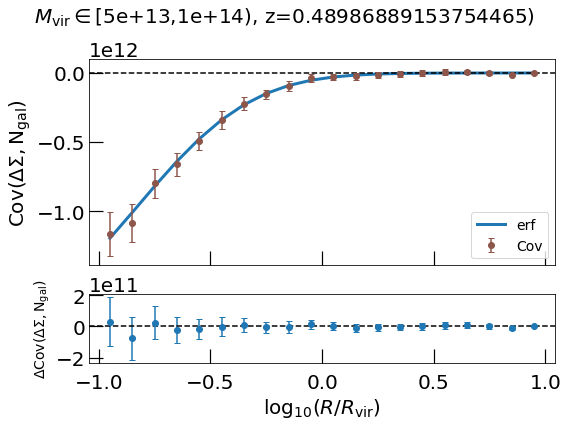

M5e+13-1e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 500.911196
         Iterations: 307
         Function evaluations: 634


100%|██████████| 10000/10000 [00:58<00:00, 169.65it/s]


param_0: best fit, upper_err, lower_err:  [0.27059168 0.22701552 0.10747362]
param_1: best fit, upper_err, lower_err:  [-0.41318547  0.09968305  0.22770898]
param_2: best fit, upper_err, lower_err:  [-0.98822327  0.02533673  0.02275603]
param_3: best fit, upper_err, lower_err:  [1.15095490e+11 6.04999678e+10 2.43764247e+10]
DIC:  [1011.04418494]
BIC:  [1014.25749387]
Chi-square p-value:  0.6600226683799266
Starting params:  [ 2.10267366e-01 -3.67286898e-01 -9.86781779e-01  1.07906858e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [173.7086241  213.0668339   49.76188542 229.02079917]


Autocorrelation:  [173.7086241  213.0668339   49.76188542 229.02079917]
R = [1.0403449  1.07306738 1.00108975 1.15571592]


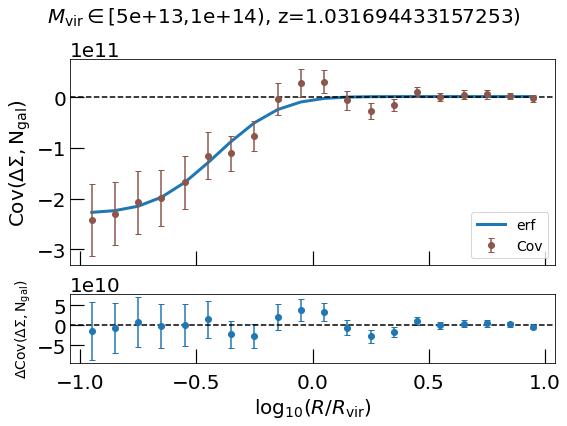

M1e+14-2e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 517.615692
         Iterations: 236
         Function evaluations: 530


100%|██████████| 10000/10000 [00:59<00:00, 169.49it/s]


param_0: best fit, upper_err, lower_err:  [0.44919544 0.09997573 0.06902503]
param_1: best fit, upper_err, lower_err:  [-0.67938512  0.10159309  0.16618377]
param_2: best fit, upper_err, lower_err:  [-1.0043889   0.01128232  0.01404721]
param_3: best fit, upper_err, lower_err:  [1.26906303e+12 5.09534853e+11 2.56225569e+11]
DIC:  [1043.45995121]
BIC:  [1047.30958513]
Chi-square p-value:  0.9998703678403397
Starting params:  [ 4.28799119e-01 -6.51789749e-01 -1.00732529e+00  1.20320499e+12] Minimization convergence:  True
Autocorrelation:  [120.17969471 142.54435923  58.2011444  159.29177936]
R = [1.00684819 1.00920704 1.00173211 1.0147006 ]


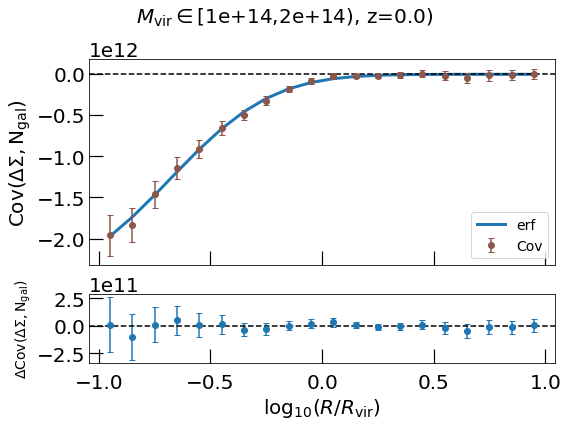

M1e+14-2e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 510.104992
         Iterations: 283
         Function evaluations: 602


100%|██████████| 10000/10000 [01:05<00:00, 153.45it/s]


param_0: best fit, upper_err, lower_err:  [0.31955035 0.14684942 0.08660875]
param_1: best fit, upper_err, lower_err:  [-0.54867442  0.08089524  0.18372358]
param_2: best fit, upper_err, lower_err:  [-0.99052899  0.01328858  0.01167421]
param_3: best fit, upper_err, lower_err:  [3.85040631e+11 1.94784389e+11 7.52057932e+10]
DIC:  [1028.76321511]
BIC:  [1032.49076477]
Chi-square p-value:  0.563396747592279
Starting params:  [ 2.75544396e-01 -5.10742024e-01 -9.90024047e-01  3.53604653e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [165.55013606 202.06853258  56.14620452 221.46397723]


Autocorrelation:  [165.55013606 202.06853258  56.14620452 221.46397723]
R = [1.02556164 1.04812533 1.00284667 1.09054127]


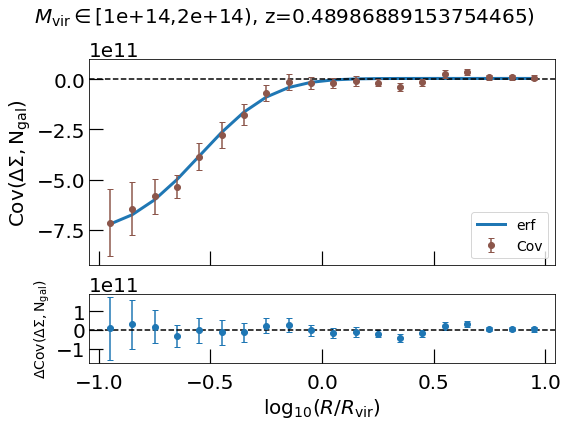

M1e+14-2e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 502.059992
         Iterations: 329
         Function evaluations: 672


100%|██████████| 10000/10000 [01:07<00:00, 148.65it/s]


param_0: best fit, upper_err, lower_err:  [0.32865761 0.30076067 0.13800329]
param_1: best fit, upper_err, lower_err:  [-0.60208153  0.15897693  0.45849156]
param_2: best fit, upper_err, lower_err:  [-0.96958762  0.03451324  0.02139404]
param_3: best fit, upper_err, lower_err:  [1.47515124e+11 2.08379802e+11 5.71610835e+10]
DIC:  [1013.95654201]
BIC:  [1016.89683722]
Chi-square p-value:  0.563690597118256
Starting params:  [ 2.50631217e-01 -5.25995759e-01 -9.63788739e-01  1.36103083e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [173.72261491 213.69005429 151.87313333 242.14124046]


Autocorrelation:  [173.72261491 213.69005429 151.87313333 242.14124046]
R = [1.01254594 1.02783459 1.01905621 1.15393601]


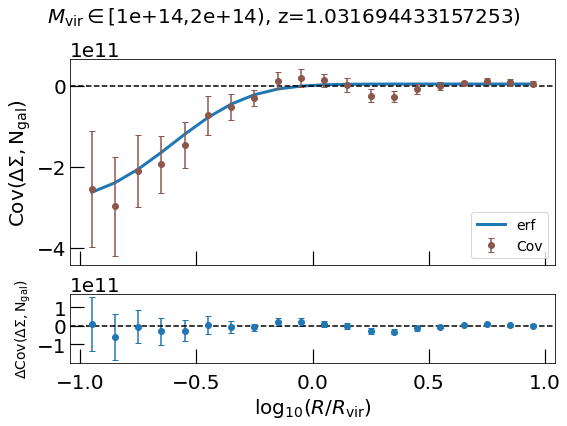

M2e+14-5e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 515.318327
         Iterations: 226
         Function evaluations: 515


100%|██████████| 10000/10000 [01:05<00:00, 151.92it/s]


param_0: best fit, upper_err, lower_err:  [0.30636425 0.04035353 0.03605854]
param_1: best fit, upper_err, lower_err:  [-0.50155107  0.04722128  0.05852415]
param_2: best fit, upper_err, lower_err:  [-0.99838286  0.00967818  0.00988063]
param_3: best fit, upper_err, lower_err:  [8.79457449e+11 1.35284926e+11 1.06544940e+11]
DIC:  [1038.77503584]
BIC:  [1042.64851032]
Chi-square p-value:  0.9498379960105293
Starting params:  [ 3.02326359e-01 -4.97798313e-01 -9.98778748e-01  8.76970539e+11] Minimization convergence:  True
Autocorrelation:  [49.31069589 49.64242438 44.19539583 50.81580725]
R = [1.00221066 1.00212618 1.00162044 1.00304171]


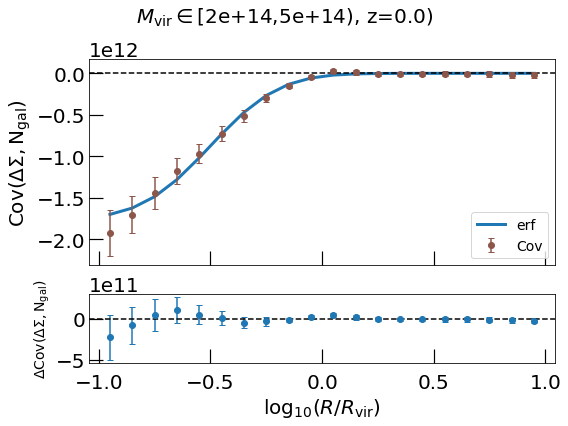

M2e+14-5e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 510.283654
         Iterations: 281
         Function evaluations: 596


100%|██████████| 10000/10000 [01:06<00:00, 149.80it/s]


param_0: best fit, upper_err, lower_err:  [0.72569256 0.25501163 0.17590852]
param_1: best fit, upper_err, lower_err:  [-0.9181923   0.35822135  0.63301018]
param_2: best fit, upper_err, lower_err:  [-0.9943425   0.0102446   0.00555574]
param_3: best fit, upper_err, lower_err:  [6.48074034e+11 1.03262230e+12 2.93520595e+11]
DIC:  [1027.99176255]
BIC:  [1032.81344251]
Chi-square p-value:  0.8984162566802701
Starting params:  [ 7.43890428e-01 -9.93891711e-01 -9.94091655e-01  7.77998692e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [210.58623372 264.65722834  84.58137268 309.01354606]


Autocorrelation:  [210.58623372 264.65722834  84.58137268 309.01354606]
R = [1.01397115 1.02051165 1.00517444 1.03557556]


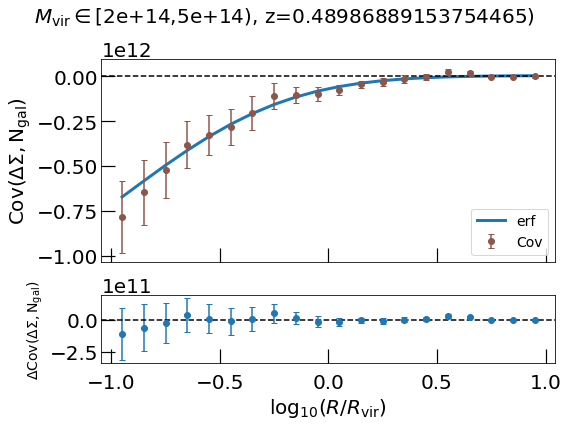

M2e+14-5e+14, z=1.03, 349
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [01:05<00:00, 152.79it/s]


param_0: best fit, upper_err, lower_err:  [0.16831691 1.81042591 0.10904164]
param_1: best fit, upper_err, lower_err:  [0.02582245 0.08732518 0.1168291 ]
param_2: best fit, upper_err, lower_err:  [-0.63195342  0.30888003  0.13376124]
param_3: best fit, upper_err, lower_err:  [2.58475386e+10 1.34134999e+10 8.68966371e+09]
DIC:  [1028.59661421]
BIC:  [1027.59807597]
Chi-square p-value:  0.007074989353490713
Starting params:  [ 1.23372003e-11  5.00000000e-02 -6.58836418e-01  2.58257950e+10] Minimization convergence:  False


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [530.81167753 358.39313061 358.85786293 441.7669768 ]


Autocorrelation:  [530.81167753 358.39313061 358.85786293 441.7669768 ]
R = [1.05217257 1.03668241 1.05341612 1.04036206]


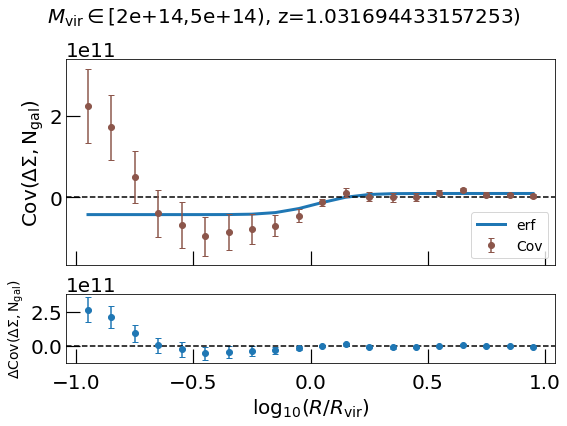

M5e+14-1e+15, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 510.895023
         Iterations: 238
         Function evaluations: 535


100%|██████████| 10000/10000 [01:06<00:00, 150.14it/s]


param_0: best fit, upper_err, lower_err:  [0.48327931 0.12542903 0.08972451]
param_1: best fit, upper_err, lower_err:  [-0.75215835  0.14296057  0.25788847]
param_2: best fit, upper_err, lower_err:  [-0.99118875  0.00703231  0.0057078 ]
param_3: best fit, upper_err, lower_err:  [1.07552671e+12 7.30259142e+11 2.91166598e+11]
DIC:  [1029.76196355]
BIC:  [1033.89340175]
Chi-square p-value:  0.9728192325894175
Starting params:  [ 4.62555671e-01 -7.23065528e-01 -9.90328523e-01  1.02407685e+12] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [176.66446727 201.59425571  69.79354151 222.76859552]


Autocorrelation:  [176.66446727 201.59425571  69.79354151 222.76859552]
R = [1.02020172 1.02723148 1.00150632 1.04934602]


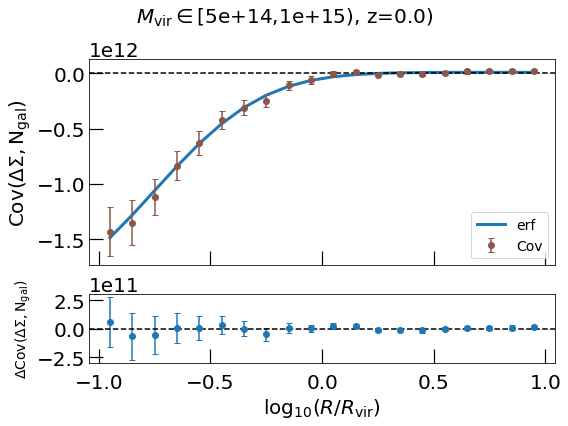

M5e+14-1e+15, z=0.49, 180
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [01:05<00:00, 153.74it/s]


param_0: best fit, upper_err, lower_err:  [5.09864584 3.298426   3.2105466 ]
param_1: best fit, upper_err, lower_err:  [-0.05066735  3.15800371  3.2158329 ]
param_2: best fit, upper_err, lower_err:  [-0.22885675  0.66301206  0.66407608]
param_3: best fit, upper_err, lower_err:  [2.39649764e+10 5.88085620e+10 1.14108898e+10]
DIC:  [1046.044072]
BIC:  [1056.40165559]
Chi-square p-value:  0.6305623719948308
Starting params:  [8.91973716e+00 1.83994662e+00 1.31313698e-01 2.54790933e+11] Minimization convergence:  False
Autocorrelation:  [122.37992411 121.76057826 123.00754827 199.27893202]
R = [1.00268784 1.00620349 1.00468897 1.01226692]


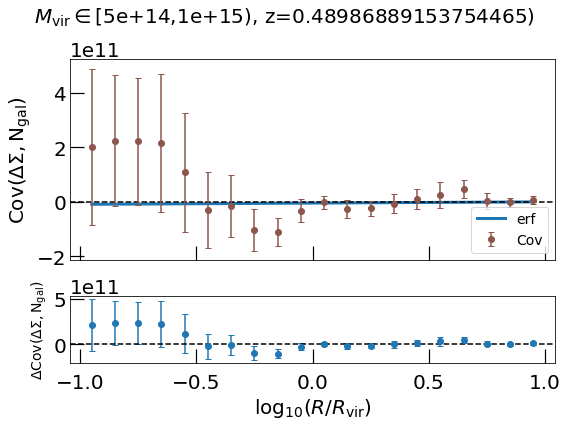

M5e+14-1e+15, z=1.03, 0


In [34]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_Rvir'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                if key != 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chains_dir+"Rvir_binned/Dsep_Rvir/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

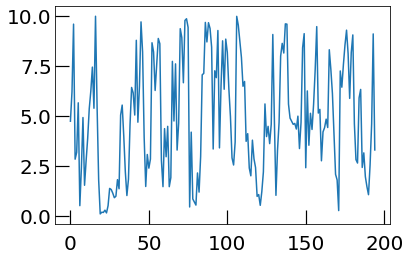

In [26]:
np.shape(flatchain)
plt.plot(flatchain[:,0,0])
flatchain = flatchain.reshape((-1,4)).T

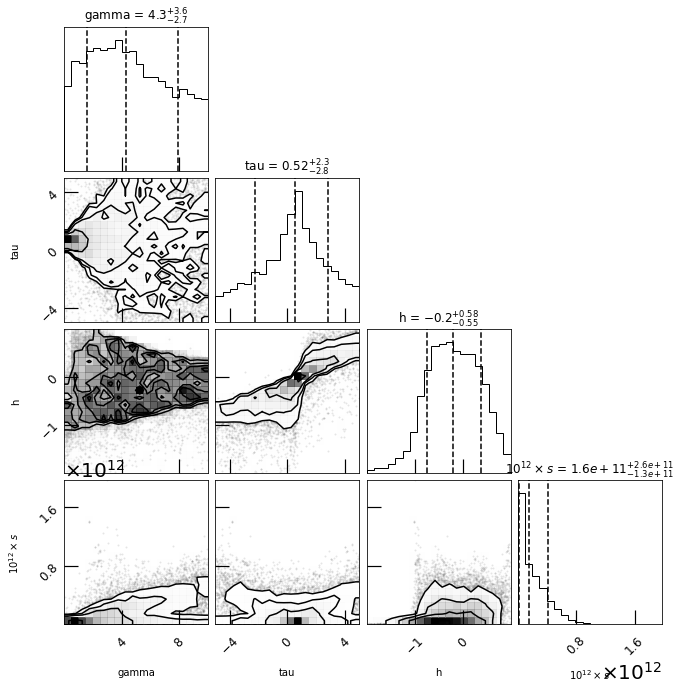

In [27]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')